In [1]:
# import numpy as np

# # !/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on 20181219

# @author: zhangji

# Trajection of a ellipse, Jeffery equation. 
# """

# %pylab inline
# pylab.rcParams['figure.figsize'] = (25, 11)
# fontsize = 40

# import numpy as np
# import scipy as sp
# from scipy.optimize import leastsq, curve_fit
# from scipy import interpolate
# from scipy.interpolate import interp1d
# from scipy.io import loadmat, savemat
# # import scipy.misc

# import matplotlib
# from matplotlib import pyplot as plt
# from matplotlib import animation, rc
# import matplotlib.ticker as mtick
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
# from mpl_toolkits.mplot3d import Axes3D, axes3d

# from sympy import symbols, simplify, series, exp
# from sympy.matrices import Matrix
# from sympy.solvers import solve

# from IPython.display import display, HTML
# from tqdm import tqdm_notebook as tqdm
# import pandas as pd
# import re
# from scanf import scanf
# import os
# import glob

# from codeStore import support_fun as spf
# from src.support_class import *
# from src import stokes_flow as sf

# rc('animation', html='html5')
# PWD = os.getcwd()
# font = {'size': 20}
# matplotlib.rc('font', **font)
# np.set_printoptions(linewidth=90, precision=5)

%load_ext autoreload
%autoreload 2

import os
import glob
import natsort 
import numpy as np
import scipy as sp
from scipy.optimize import leastsq, curve_fit
from scipy import interpolate, integrate
from scipy import spatial, signal
# from scipy.interpolate import interp1d
from scipy.io import loadmat, savemat
# import scipy.misc
# import importlib
from IPython.display import display, HTML
import pandas as pd
import pickle
import re
from scanf import scanf

import matplotlib
# matplotlib.use('agg')
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from matplotlib import animation, rc
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.mplot3d import Axes3D, axes3d
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib import cm

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm
from time import time
from src.support_class import *
from src import jeffery_model as jm
from codeStore import support_fun as spf
from codeStore import support_fun_table as spf_tb
import spectrum

# %matplotlib notebook
%matplotlib inline
rc('animation', html='html5')
fontsize = 40
PWD = os.getcwd()

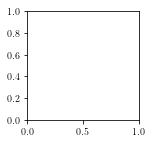

In [37]:
fig = plt.figure(figsize=(2, 2))
fig.patch.set_facecolor('white')
ax0 = fig.add_subplot(1, 1, 1)

In [75]:
# job_dir = 'ecoC01B05_passive_psi-0b'
# job_dir = 'ecoC01B05_passive_psi-0.000c'
# job_dir = 'ecoC01B05_passive_psi-0.785c'
# job_dir = 'ecoC01B05_passive_psi-1.571c'
# job_dir = 'ecoC01B05_passive_psi-2.356c'
# job_dir = 'ecoC01B05_passive_psi-3.142c'
# job_dir = 'ecoC01B05_passive_psi-3.927c'
# job_dir = 'ecoC01B05_passive_psi-4.712c'
job_dir = 'ecoC01B05_passive_psi-5.498c'
# table_name = 'ecoC01B05_tao1_wm0'
t_headle = '(.*?).pickle'

In [76]:
t_dir = os.path.join(PWD, job_dir)

data = spf_tb.load_table_data_pickle_dir(t_dir, t_headle)
lst_eta = data.lst_eta
theta_max_fre = data.theta_max_fre
phi_max_fre = data.phi_max_fre
psi_max_fre = data.psi_max_fre
eta_max_fre = data.eta_max_fre
data_idx = data.data_idx.fillna(-1).astype(int)

In [ ]:
# show phase map of theta-phi, load date
t_headle = '(.*?).pickle'
t_path = os.listdir(os.path.join(PWD, job_dir))
filename_list = [filename for filename in os.listdir(os.path.join(PWD, job_dir)) 
                 if re.match(t_headle, filename) is not None]
ini_theta_list = []
ini_phi_list = []
lst_eta_list = []
theta_primary_fre_list = []
phi_primary_fre_list = []
psi_primary_fre_list = []
eta_primary_fre_list = []
dx_list = []
dy_list = []
dz_list = []
pickle_path_list = []
idx_list = []
for i0, tname in enumerate(tqdm_notebook(filename_list[:])):
    tpath = os.path.join(PWD, job_dir, tname)
    with open(tpath, 'rb') as handle:
        tpick = pickle.load(handle)
    ini_theta_list.append(tpick['ini_theta'])
    ini_phi_list.append(tpick['ini_phi'])
    lst_eta_list.append(tpick['Table_eta'][-1])
    pickle_path_list.append(tpath)
    idx_list.append(i0)
    
    # fft rule
    tx = tpick['Table_t']
    tmin = np.max((0, tx.max() - 1000))
    idx = tx > tmin    
    freq_pk = spf_tb.get_major_fre(tx[idx], tpick['Table_theta'][idx])
    idx = tx > (tx.max() - 1 / freq_pk * 10)
    theta_primary_fre_list.append(spf_tb.get_primary_fft_fre(tx[idx], tpick['Table_theta'][idx], cos_mode=True)[-10:])
    phi_primary_fre_list.append(spf_tb.get_primary_fft_fre(tx[idx], tpick['Table_phi'][idx], cos_mode=True)[-10:])
    psi_primary_fre_list.append(spf_tb.get_primary_fft_fre(tx[idx], tpick['Table_psi'][idx], cos_mode=True)[-10:])
    eta_primary_fre_list.append(spf_tb.get_primary_fft_fre(tx[idx], tpick['Table_eta'][idx], cos_mode=True)[-10:])
    for i0, tlist in enumerate((dx_list, dy_list, dz_list)):
        tpoly = np.polyfit(tx[idx], tpick['Table_X'][idx, i0], 1, w=np.blackman(idx.sum()))
        tlist.append(tpoly[0])

filename_list = np.array(filename_list)
ini_theta_list = np.hstack(ini_theta_list)
ini_phi_list = np.hstack(ini_phi_list)
lst_eta_list = np.hstack(lst_eta_list)
theta_primary_fre_list = np.array(theta_primary_fre_list)
phi_primary_fre_list = np.array(phi_primary_fre_list)
psi_primary_fre_list = np.array(psi_primary_fre_list)
eta_primary_fre_list = np.array(eta_primary_fre_list)
dx_list = np.hstack(dx_list)
dy_list = np.hstack(dy_list)
dz_list = np.hstack(dz_list)
pickle_path_list = np.array(pickle_path_list)

-ini_theta 0.142800 -ini_phi 0.000000 -ini_psi 1.570796


ValueError: Expect x to be a 1-D sorted array_like.

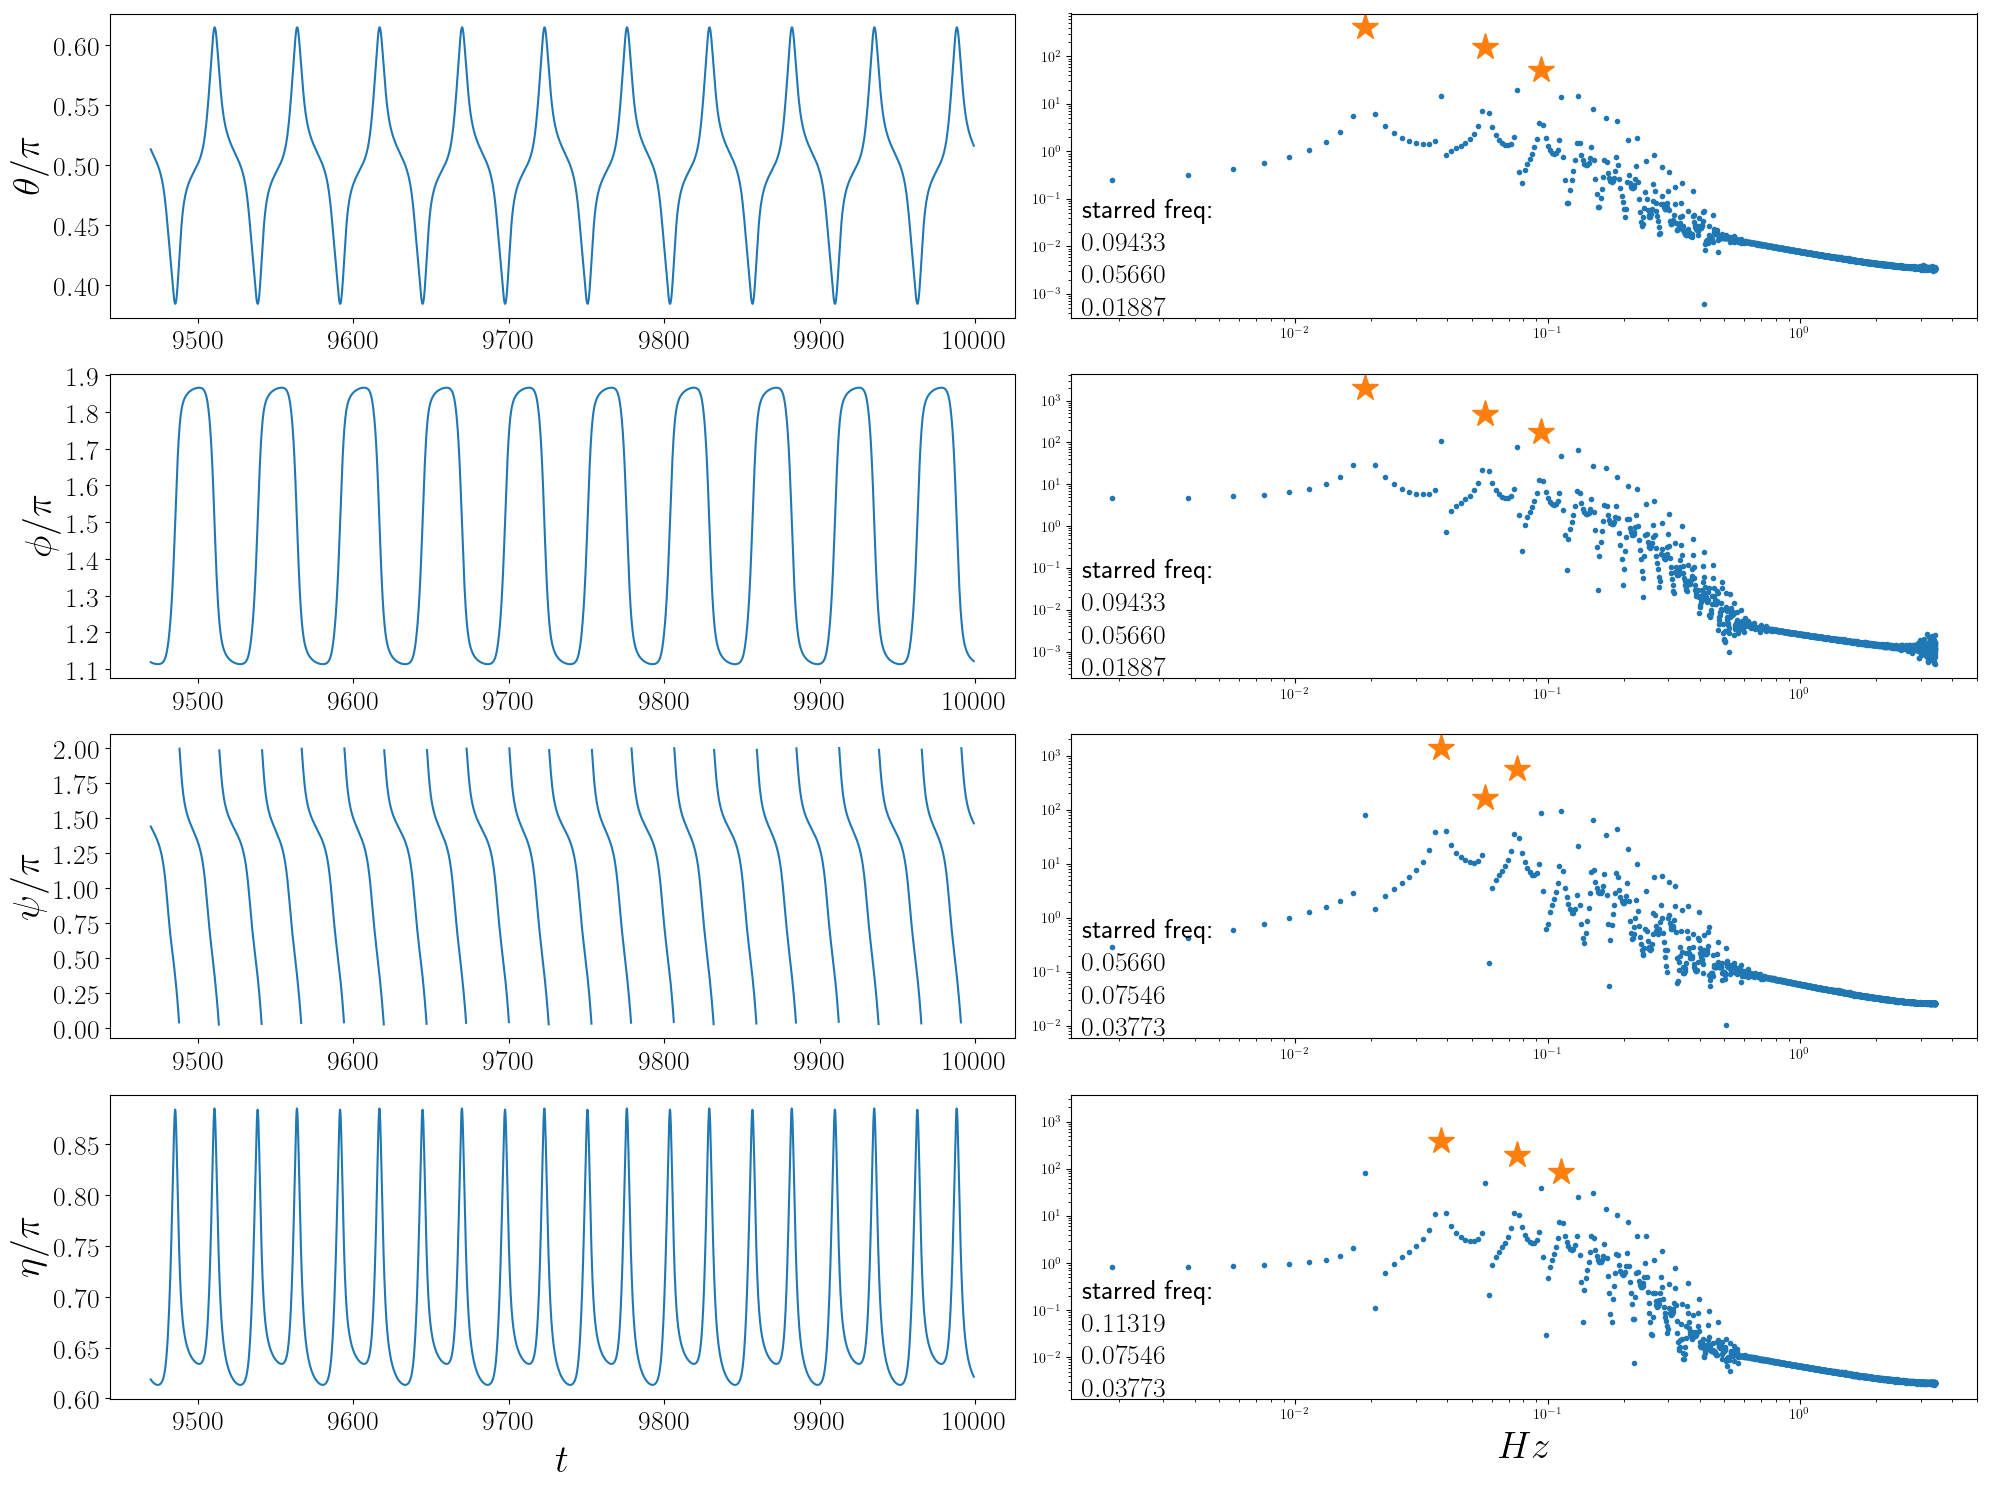

In [46]:
theta, phi = 0.0000, 1.714
theta, phi = 0.1430, 0.000

tpick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
Table_t = tpick['Table_t']
Table_dt = tpick['Table_dt']
Table_X = tpick['Table_X']
Table_P = tpick['Table_P']
Table_P2 = tpick['Table_P2']
Table_theta = tpick['Table_theta']
Table_phi = tpick['Table_phi']
Table_psi = tpick['Table_psi']
Table_eta = tpick['Table_eta']
print('-ini_theta %f -ini_phi %f -ini_psi %f' % 
      (tpick['Table_theta'][0], tpick['Table_phi'][0], tpick['Table_psi'][0]))

freq_pk = spf_tb.get_major_fre(Table_t, Table_theta)
idx = Table_t > Table_t.max() - 1 / freq_pk * 10
# spf_tb.show_table_result(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                          Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], save_every)
# spf_tb.show_theta_phi(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                       Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], show_back_direction=False)
spf_tb.show_theta_phi_psi_eta(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
                              Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx])
# spf_tb.show_center_X(Table_t[idx], Table_dt[idx], Table_X[idx], Table_P[idx], Table_P2[idx], 
#                      Table_theta[idx], Table_phi[idx], Table_psi[idx], Table_eta[idx], 
#                      table_name=table_name)

_ = spf_tb.resampling_data(Table_t, Table_dt, Table_X, Table_P, Table_P2,
                           Table_theta, Table_phi, Table_psi, Table_eta, resampling_fct=2)
Table_t, Table_dt, Table_X, Table_P, Table_P2, Table_theta, Table_phi, Table_psi, Table_eta = _

In [5]:
def _plot_fft(use_t, ty, f2, Pxx_den, figsize=np.array((16, 9)) * 0.5, dpi=100, show_prim_freq=3):
    fig, axs = plt.subplots(1, 2, figsize=figsize, dpi=dpi)
    fig.patch.set_facecolor('white')
    axi = axs[0]
    axi.plot(use_t, ty, '.-')
    axi = axs[1]
    axi.loglog(f2, Pxx_den, '.')
    tpk = signal.find_peaks(Pxx_den)[0]
    fft_abs_pk = Pxx_den[tpk]
    freq_pk = f2[tpk]
    tidx = np.argsort(fft_abs_pk)[-show_prim_freq:]
    axi.loglog(freq_pk[tidx], fft_abs_pk[tidx], '*')
    t1 = 'starred freq: \n' + '\n'.join(['$%.5f$' % freq_pk[ti] for ti in tidx])
    axi.text(axi.get_xlim()[0] * 1.1, axi.get_ylim()[0] * 2, t1)
    
f2 = 10 ** np.linspace(-3, 2, 10000)
# f2 = np.linspace(0.001, 1, 10000)
Pxx_den = signal.lombscargle(use_t[idx], ty[idx], freqs=f2)
_plot_fft(use_t[idx], ty[idx], f2, Pxx_den, figsize=figsize, dpi=dpi, show_prim_freq=show_prim_freq)

NameError: name 'use_t' is not defined

In [6]:
fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi = axs.ravel()[0]
axi.plot(use_t[idx], Table_P[:, 1][idx] / np.pi, '.-')
axi.set_xlabel('$t$')
axi.set_ylabel('$\\theta / \\pi$')
axi = axs.ravel()[1]
axi.plot(use_t[idx], np.cos(Table_P[:, 1])[idx], '.-')
axi.set_xlabel('$t$')
axi.set_ylabel('$\\cos \\theta$')
axi = axs.ravel()[2]
autocorr_theta = np.correlate(Table_P[:, 1][idx], Table_P[:, 1][idx], mode='full')[idx.sum()-1:]
axi.plot(use_t[idx], autocorr_theta, '.-')
axi.set_xlabel('$\\delta t$')
axi.set_ylabel('$R_\\theta$')
axi = axs.ravel()[3]
autocorr_theta = np.correlate(np.cos(Table_P[:, 1])[idx], np.cos(Table_P[:, 1])[idx], mode='full')[idx.sum()-1:]
axi.plot(use_t[idx], autocorr_theta, '.-')
axi.set_xlabel('$\\delta t$')
axi.set_ylabel('$R_{\\cos \\theta}$')
fig.tight_layout()

NameError: name 'figsize' is not defined

In [ ]:
np.argmax([])

NameError: name 'resamp_theta' is not defined

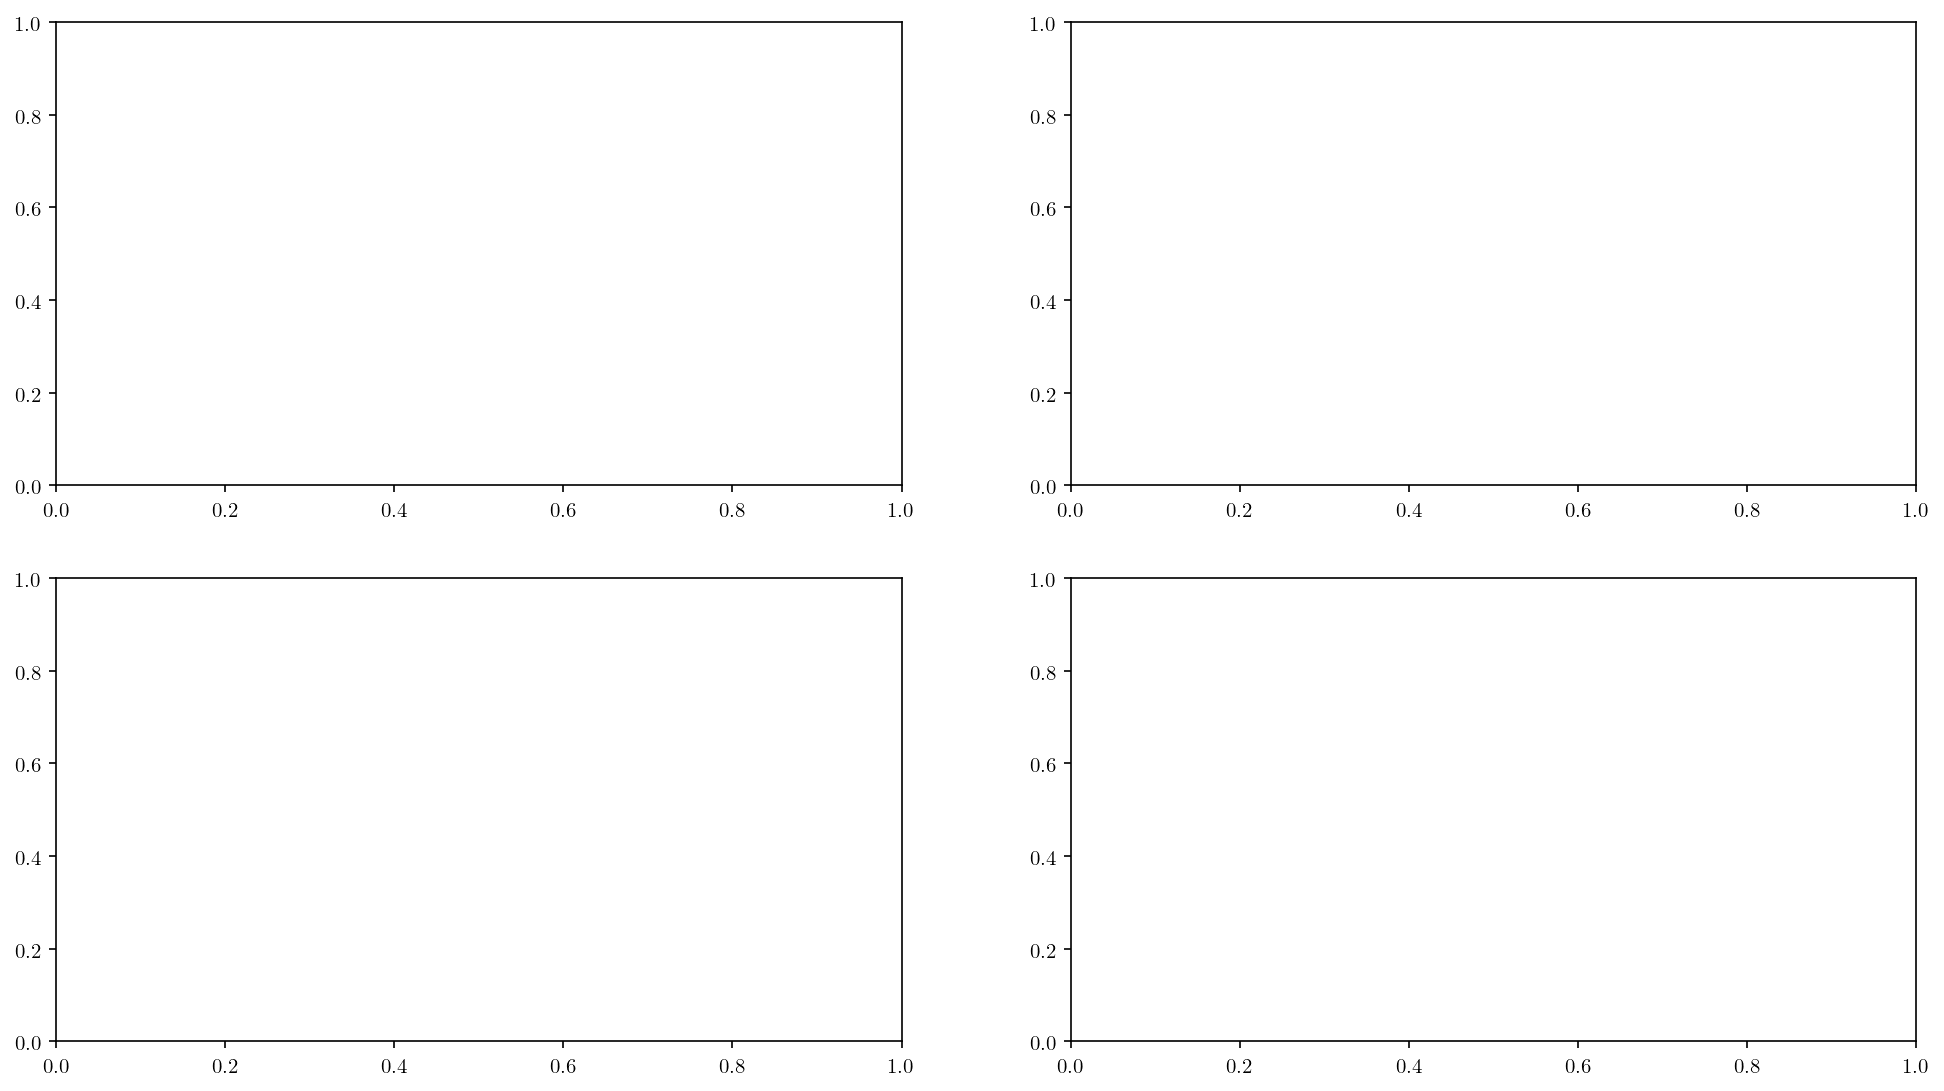

In [7]:
figsize = np.array((16, 9))
dpi = 150
show_prim_freq = 3

use_t = np.linspace(Table_t.min(), Table_t.max(), 1 * Table_t.size)
# resamp_theta = spf_tb.get_continue_angle(Table_t, Table_theta, use_t)
# resamp_phi = spf_tb.get_continue_angle(Table_t, Table_phi, use_t)
# resamp_psi = spf_tb.get_continue_angle(Table_t, Table_psi, use_t)
ty = np.cos(Table_theta)
# ty = Table_P[:, 1]
# ty = resamp_theta
idx = np.zeros_like(use_t, dtype='bool')
idx[-10000:] = True

fig, axs = plt.subplots(2, 2, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi = axs.ravel()[0]
axi.plot(use_t[idx], resamp_theta[idx] / np.pi, '.-')
axi.set_xlabel('$t$')
axi.set_ylabel('$\\theta / \\pi$')
axi = axs.ravel()[1]
axi.plot(use_t[idx], np.cos(resamp_theta)[idx], '.-')
axi.set_xlabel('$t$')
axi.set_ylabel('$\\cos \\theta$')
axi = axs.ravel()[2]
autocorr_theta = np.correlate(resamp_theta[idx], resamp_theta[idx], mode='full')[idx.sum()-1:]
axi.plot(use_t[idx], autocorr_theta, '.-')
axi.set_xlabel('$\\delta t$')
axi.set_ylabel('$R_\\theta$')
axi = axs.ravel()[3]
autocorr_theta = np.correlate(np.cos(resamp_theta)[idx], np.cos(resamp_theta)[idx], mode='full')[idx.sum()-1:]
axi.plot(use_t[idx], autocorr_theta, '.-')
axi.set_xlabel('$\\delta t$')
axi.set_ylabel('$R_{\\cos \\theta}$')
fig.tight_layout()


fig, axs = plt.subplots(3, 5, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
win_fun_list = ['boxcar', 'triang', 'blackman', 'hamming', 'hann', 'bartlett', 'flattop', 'parzen', 'bohman', 
                'blackmanharris', 'nuttall', 'barthann', ('gaussian', 200), ('gaussian', 500), ('gaussian', 1000), ]
for win_fun, axi in zip(win_fun_list, axs.ravel()):
    Pxx_den = np.abs(np.fft.rfft(ty[idx] * signal.get_window(win_fun, idx.sum()))) / np.sqrt(idx.sum())
    f2 = np.fft.rfftfreq(use_t[idx].size, np.mean(np.diff(use_t[idx])))
    axi.loglog(f2, Pxx_den, '-')
    axi.set_title(win_fun)
    axi.set_ylim(1e-10, 50)
#     print(Pxx_den.max())
fig.tight_layout()

# fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
# fig.patch.set_facecolor('white')
# axi = axs
# win_fun_list = ['boxcar']
# for win_fun in win_fun_list:
#     Pxx_den = np.abs(np.fft.rfft(ty[idx] * signal.get_window(win_fun, idx.sum())))
# #     Pxx_den = Pxx_den ** 2 / idx.sum()
#     f2 = np.fft.rfftfreq(use_t[idx].size, np.mean(np.diff(use_t[idx])))
#     axi.loglog(f2, Pxx_den, '-', label=win_fun)
#     print(Pxx_den.max())
# axi.legend()
# fig.tight_layout()

fig, axs = plt.subplots(1, 1, figsize=figsize, dpi=dpi)
fig.patch.set_facecolor('white')
axi = axs
fs = ty[idx].size / (use_t[idx].max() - use_t[idx].min())

tfft = np.fft.rfft(ty[idx])
Pxx_den = np.conjugate(tfft) * tfft / idx.sum() / fs
f2 = np.fft.rfftfreq(use_t[idx].size, np.mean(np.diff(use_t[idx])))
axi.loglog(f2, Pxx_den.real, '-', label='power spectral density')
# print(np.abs(Pxx_den).max())

Pxx_den = np.abs(np.fft.rfft(ty[idx])) / np.sqrt(idx.sum())
f2 = np.fft.rfftfreq(use_t[idx].size, np.mean(np.diff(use_t[idx])))
axi.loglog(f2, Pxx_den, '-', label='FFT')
# print(np.abs(Pxx_den).max())
  
Pxx_den = np.abs(np.fft.rfft(np.correlate(ty[idx], ty[idx], mode='full')[idx.sum()-1:]))
Pxx_den = Pxx_den / idx.sum() / fs * 2
f2 = np.fft.rfftfreq(use_t[idx].size, np.mean(np.diff(use_t[idx])))
axi.loglog(f2, Pxx_den, '-', label='autocorrelation')
# print(np.abs(Pxx_den).max())
axi.legend()

# f2 = 10 ** np.linspace(-3, 3, 10000)
# # f2 = np.linspace(0.001, 1, 10000) 
# Pxx_den = signal.lombscargle(use_t[idx], ty[idx], freqs=f2)
# _plot_fft(use_t[idx], ty[idx], f2, Pxx_den, figsize=figsize, dpi=dpi, show_prim_freq=show_prim_freq)

True

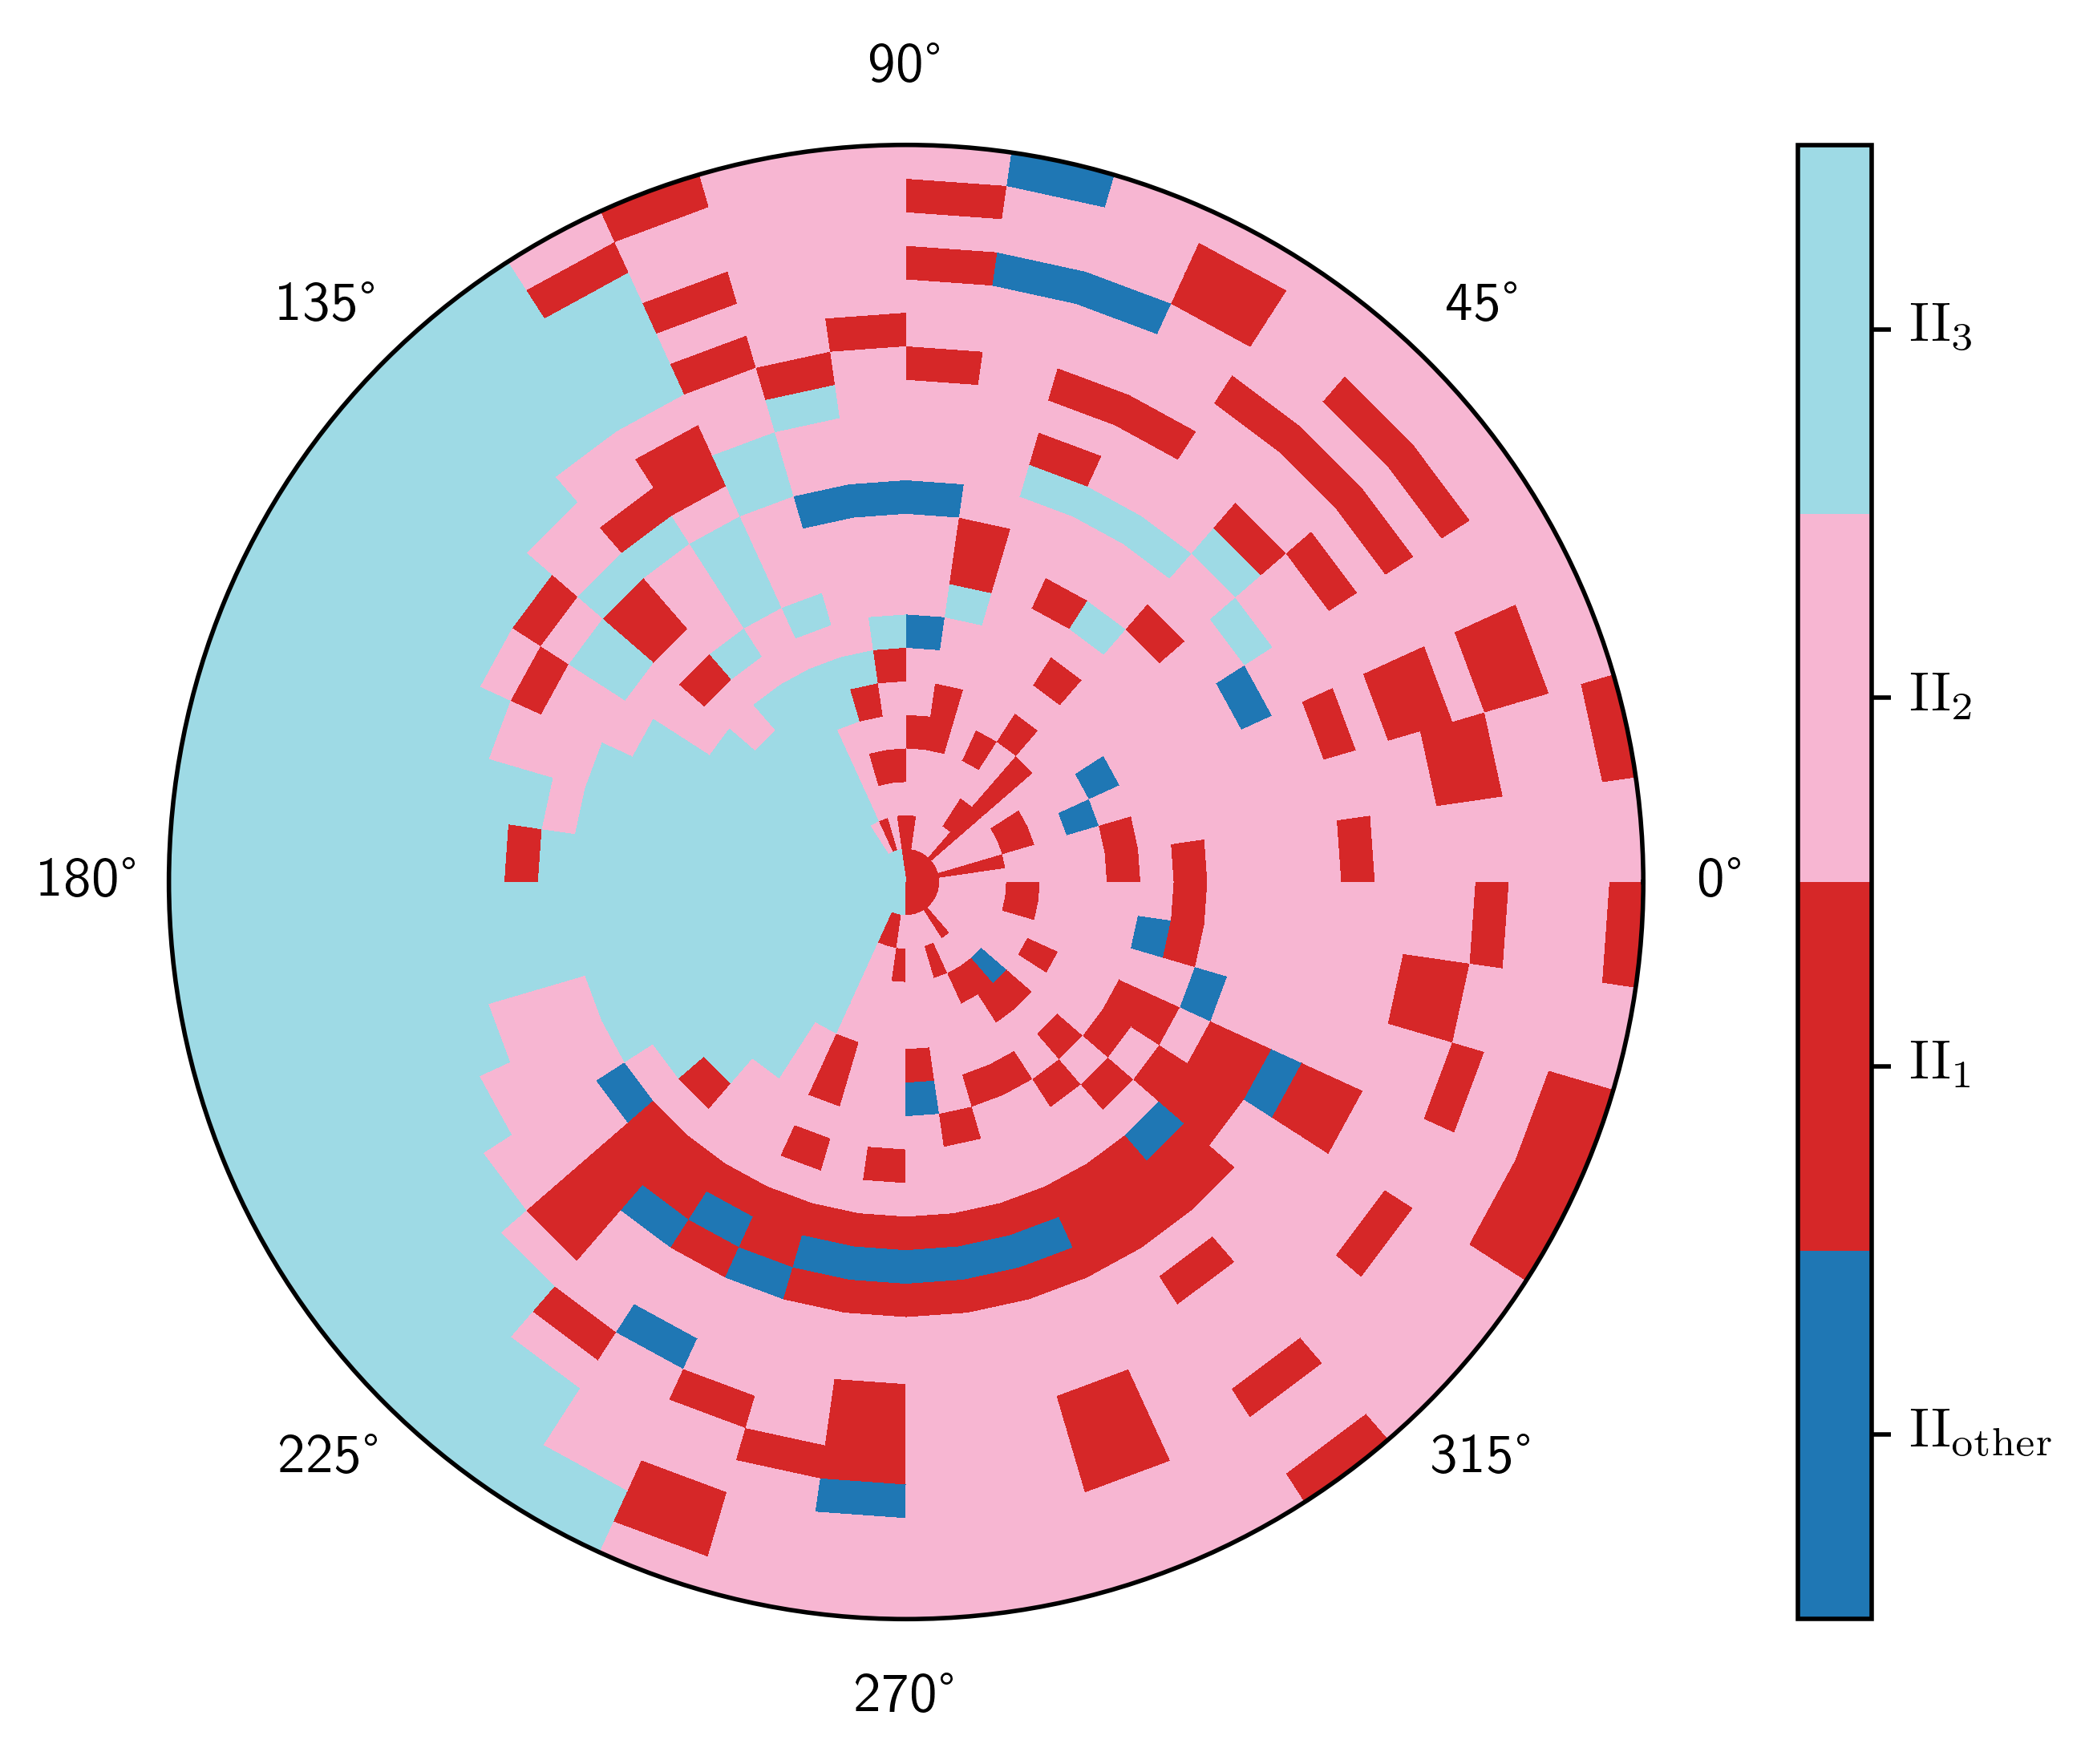

In [77]:
# put images with same frequence into a subdirect
check_fre_list = [0.0160, 0.0190, 0.0203, 0.0632]
atol_fre_list =  [0.0001, 0.0001, 0.0008, 0.0008]
Table_t_range = np.array((4500, np.inf))

def sub_seperate_0(i1, type_fre, iidx, Table_t_range):
    t1 = np.zeros_like(iidx[0])
    return t1

def sub_seperate_1(i1, type_fre, iidx, Table_t_range):
    theta = type_fre.index.values[iidx[0]]
    phi = type_fre.columns.values[iidx[1]]
    theta_phi_list = np.vstack((theta, phi)).T
    tuse = []
    for theta, phi in tqdm_notebook(theta_phi_list, desc='No. %d  ' % i1):
        tpick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
        Table_t = tpick['Table_t']
        Table_theta = tpick['Table_theta']
        Table_phi = tpick['Table_phi']
        Table_psi = tpick['Table_psi']
        
        idx = np.logical_and(Table_t >= Table_t_range[0], Table_t <= Table_t_range[1])
        tuse.append(np.max(Table_theta[idx]))
    tuse = np.hstack(tuse)
    t1 = np.ones_like(tuse)
    t1[tuse < 1.6] = 0
    t1[tuse > 1.934] = 2
    return t1

def sub_seperate_2(i1, type_fre, iidx, Table_t_range):
    theta = type_fre.index.values[iidx[0]]
    phi = type_fre.columns.values[iidx[1]]
    theta_phi_list = np.vstack((theta, phi)).T
    tuse = []
    for theta, phi in tqdm_notebook(theta_phi_list, desc='No. %d  ' % i1):
        tpick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
        Table_t = tpick['Table_t']
        Table_theta = tpick['Table_theta']
        Table_phi = tpick['Table_phi']
        Table_psi = tpick['Table_psi']
        
        idx = np.logical_and(Table_t >= Table_t_range[0], Table_t <= Table_t_range[1])
        tuse.append(np.max(Table_phi[idx]))
    tuse = np.hstack(tuse)
    t1 = np.ones_like(tuse)
    t1[tuse < 4] = 0
    t1[tuse > 5.1] = 2
    return t1
    
sub_seperate = {0: sub_seperate_0, 
                1: sub_seperate_1, 
                2: sub_seperate_2, 
                3: sub_seperate_0, }

tfre = theta_max_fre.copy()
type_fre = tfre.copy()
type_fre.iloc[:, :] = -1
i0 = 0
process_total = 0
for i1, (check_fre, atol_fre) in enumerate(zip(check_fre_list[:], atol_fre_list)):
    use_idx = np.isclose(tfre, check_fre, rtol=0, atol=atol_fre)
    iidx = np.where(use_idx)
    process_total = process_total + np.sum(use_idx)
    t1 = sub_seperate[i1](i1, type_fre, iidx, Table_t_range)
    type_fre.iloc[use_idx] = i0 + t1
    i0 = i0 + 1 + np.max(t1)

# plot one of the remaind cases
if np.any(type_fre.values == -1):
    pass

assert np.any(type_fre.values > 0)

# ticklabels = None
# figsize = np.array((16, 9)) * 0.5
# dpi = 500
# type_fre2 = type_fre.copy()
# type_fre2.iloc[type_fre.values == 0] = 0
# type_fre2.iloc[type_fre.values == 1] = 1
# type_fre2.iloc[type_fre.values == 2] = 2
# type_fre2.iloc[type_fre.values == 3] = 3
# type_fre2.iloc[type_fre.values == 4] = 1
# type_fre2.iloc[type_fre.values == 5] = 1
# type_fre2.iloc[type_fre.values == 6] = 4
# type_fre2.iloc[type_fre.values == 7] = 1

ticklabels = np.array(('$\\mathrm{II_{other}}$', 
                       '$\\mathrm{II_{1}}$',
                       '$\\mathrm{II_{2}}$', 
                       '$\\mathrm{II_{3}}$'))
figsize = np.array((16, 9)) * 0.5
dpi = 500
type_fre2.iloc[type_fre.values == 0] = 3
type_fre2.iloc[type_fre.values == 1] = 0
type_fre2.iloc[type_fre.values == 2] = 2
type_fre2.iloc[type_fre.values == 3] = 2
type_fre2.iloc[type_fre.values == 4] = 0
type_fre2.iloc[type_fre.values == 5] = 0
type_fre2.iloc[type_fre.values == 6] = 1
type_fre2.iloc[type_fre.values == 7] = 0
spf_tb.show_traj_phase_map_type(type_fre2, ticklabels=ticklabels, figsize=figsize, dpi=dpi)
# spf_tb.save_separate_angleList_fft(job_dir, tfre, check_fre_list, atol_fre_list)

In [71]:
job_dir

'ecoC01B05_passive_psi-4.712c'

In [49]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):   
    display(type_fre2)

ini_phi,0.000,0.143,0.286,0.428,0.571,0.714,0.857,1.000,1.142,1.285,1.428,1.571,1.714,1.856,1.999,2.142,2.285,2.428,2.570,2.713,2.856,2.999,3.142,3.284,3.427,3.570,3.713,3.856,3.998,4.141,4.284,4.427,4.570,4.712,4.855,4.998,5.141,5.284,5.426,5.569,5.712,5.855,5.998,6.140,6.283
ini_theta,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.000,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
0.143,2.0,3.0,3.0,4.0,3.0,4.0,4.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,3.0,3.0,3.0,3.0,2.0,3.0,2.0,4.0,3.0,2.0,2.0,4.0,2.0,3.0,2.0,2.0,3.0,4.0,2.0
0.286,2.0,3.0,3.0,3.0,3.0,4.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,3.0,3.0,3.0,4.0,3.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,1.0,3.0,2.0,2.0,4.0,4.0,2.0
0.428,2.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,2.0,3.0,3.0,3.0,3.0,2.0,2.0,2.0,3.0,2.0,3.0,4.0,4.0,3.0,2.0,2.0,2.0,4.0,2.0
0.571,2.0,4.0,4.0,2.0,3.0,4.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,2.0,2.0,3.0,3.0,3.0,2.0,4.0,3.0,4.0,1.0,4.0,3.0,3.0,3.0,3.0,3.0,2.0,2.0,4.0,2.0
0.714,2.0,2.0,2.0,3.0,4.0,3.0,3.0,4.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0,2.0,2.0,2.0,2.0,2.0
0.857,2.0,2.0,4.0,2.0,3.0,4.0,3.0,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,2.0,4.0,3.0,3.0,4.0,3.0,4.0,3.0,3.0,4.0,4.0,4.0,2.0,2.0,3.0,2.0,2.0,2.0,2.0,2.0
1.000,2.0,2.0,2.0,2.0,3.0,3.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,4.0,3.0,4.0,3.0,2.0,2.0,3.0,3.0,3.0,2.0,4.0,2.0,3.0,4.0,2.0,2.0,3.0,2.0,2.0,2.0
1.142,2.0,4.0,3.0,4.0,3.0,0.0,4.0,2.0,3.0,3.0,3.0,4.0,4.0,2.0,2.0,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,3.0,4.0,4.0,2.0,2.0,2.0,4.0,3.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,2.0,4.0,2.0,2.0


In [ ]:
t1 = []
for i0 in np.arange(type_fre2.values.max() + 1):
    t1.append(np.isclose(type_fre2.values, i0).sum())

print(np.sum(t1))
print(t1)
print(t1 / np.sum(t1))

In [ ]:
nshow = np.inf
# nshow = 2
fast_mode1 = 1
figsize = np.array((16, 9)) * 0.5
dpi = 200

tipical_th_ph_list = []
for i0 in np.arange(type_fre2.values.max() + 1)[:]:
    iidx = np.where(np.isclose(type_fre2.values, i0))
    spf_tb.phase_map_show_idx(type_fre2, tipical_th_ph_list, iidx, job_dir, table_name, fast_mode=fast_mode1, )

In [ ]:
Table_t_range1 = np.array((4500, np.inf))
Table_t_range2 = np.array((4500, np.inf))
nshow = np.inf
# nshow = 2
fast_mode2 = True
figsize = np.array((16, 9)) * 0.5
dpi = 200

for i0 in np.arange(type_fre2.values.max() + 1)[:]:
    iidx = np.where(np.isclose(type_fre2.values, i0))
    spf_tb.phase_map_show_idx_list(type_fre2, iidx, job_dir, nshow=nshow, figsize=figsize, dpi=dpi, 
                                   Table_t_range1=Table_t_range1, Table_t_range2=Table_t_range2, fast_mode=fast_mode2, )

In [ ]:
# import importlib
# importlib.reload(spf_tb)

tipical_th_ph_list = [[0.   , 1.714],
                      [0.000, 0.   ],
                      [0.143, 0.   ],
                      [0.143, 0.428],
                      [0.143, 0.571]]

tipical_th_ph_use_idx = [0, 2, 3, 4, ]
Table_t_range = np.array((4500, np.inf))
figsize = np.array((16, 9)) * 0.7
dpi = 200

tipical_th_ph_list_use = np.array(tipical_th_ph_list)[tipical_th_ph_use_idx]
label_list = np.arange(len(tipical_th_ph_list))[tipical_th_ph_use_idx]
spf_tb.show_table_theta_phi_psi_fft_list(tipical_th_ph_list_use, job_dir, label_list=label_list, figsize=figsize, dpi=dpi, 
                                         use_welch=True)
spf_tb.show_table_result_list(tipical_th_ph_list_use, job_dir, label_list=label_list, Table_t_range=Table_t_range,
                              figsize=figsize, dpi=dpi)

In [ ]:
psi_lim_fct = 20
resampling_fct = 10
figsize = np.array((16, 9)) * 0.7
dpi = 200

# case_path_list = separate_fre_path_v2(type_fre2)
# color_list =     [np.array(plt.get_cmap('tab20', len(check_fre_list))(i0)[:3]).reshape((1, 3)) 
#                   for i0 in np.arange(type_fre2.values.max() + 1)]
for idx, psi_lim1 in enumerate(np.linspace(0, 2 * np.pi, psi_lim_fct * 16, endpoint=False)[::psi_lim_fct]):
    psi_lim = (psi_lim1, psi_lim1 + 2 * np.pi / (psi_lim_fct * 16))
    # create fig
    desc = '$\\psi \\in [%.3f \\pi, %.3f \\pi)$' % ((psi_lim[0] / np.pi), (psi_lim[1] / np.pi))
    fig, ax1 = plt.subplots(1, 1, figsize=figsize, dpi=dpi, subplot_kw=dict(polar=True))
    n_xticks = 32
    xticks = np.arange(n_xticks)
    ax1.set_xticks(xticks / n_xticks * 2 * np.pi)
    ax1.set_xticklabels(['$\dfrac{%d}{%d}2\pi$' % (i0, n_xticks) for i0 in xticks])
    ax1.set_yticklabels([])
    ax1.set_ylim(0, np.pi)
    fig.suptitle(desc)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    
    for i0 in np.arange(type_fre2.values.max() + 1):
        # get case_path
        iidx = np.where(np.isclose(type_fre2.values, i0))
        theta = type_fre2.index.values[iidx[0]]
        phi = type_fre2.columns.values[iidx[1]]
        theta_phi_list = np.vstack((theta, phi)).T
        case_path = []
        for theta, phi in theta_phi_list[:]:
            t_headle = 'th%5.3f_ph%5.3f_(.*?).pickle' % (theta, phi)
            filename = [filename for filename in os.listdir(job_dir)
                        if re.match(t_headle, filename) is not None][0]
            case_path.append(os.path.join(PWD, job_dir, filename))
        
        # generate fig
        thandle = ''
        color = np.array(plt.get_cmap('tab20', int(type_fre2.values.max() + 1))(int(i0))[:3]).reshape((1, 3)) 
        spf_tb.draw_phase_map_theta(case_path, color, psi_lim, axs=[ax1, ], thandle=thandle, 
                                    resampling=True, resampling_fct=resampling_fct)
    tdir = os.path.join(PWD, job_dir, 'phase_mape_fre')
    if not os.path.exists(tdir):
        os.makedirs(tdir)
    figname = os.path.join(tdir, '%04d.png' % (idx))
    fig.savefig(os.path.join(tdir, figname))
    print('save to %s' % figname)
    plt.close(fig)

In [ ]:
def _get_last_data_angle(job_dir, theta, phi, ntimes=10, resampling_fct=1):  
    base_pick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
    base_t = base_pick['Table_t']
    base_theta = base_pick['Table_theta']
    tmin = np.max((0, base_t.max() - 1000))
    idx = base_t > tmin
    freq_pk = spf_tb.get_major_fre(base_t[idx], base_theta[idx])
    idx = base_t > (base_t.max() - 1 / freq_pk * ntimes)
    base_t = base_pick['Table_t'][idx]
    base_theta = base_pick['Table_theta'][idx]
    base_phi = base_pick['Table_phi'][idx]
    base_psi = base_pick['Table_psi'][idx]
    t1 = int(np.around(1 / freq_pk * ntimes * 16 * resampling_fct))
    t_use = np.linspace(base_t.min(), base_t.max(), t1)
    base_theta = spf_tb.get_continue_angle(base_t, base_theta, t_use)
    base_phi = spf_tb.get_continue_angle(base_t, base_phi, t_use)
    base_psi = spf_tb.get_continue_angle(base_t, base_psi, t_use)
    return base_t, base_theta, base_phi, base_psi

i0 = 0
iidx = np.where(np.isclose(type_fre2.values, i0))
ttheta = type_fre2.index.values[iidx[0]][114]
tphi = type_fre2.columns.values[iidx[1]][114]
base_t, base_theta, base_phi, base_psi = _get_last_data_angle(job_dir, ttheta, tphi, ntimes=3)

In [ ]:
def _get_last_data_angle(job_dir, theta, phi, ntimes=10, resampling_fct=1):  
    base_pick, _ = spf_tb.load_table_date_pickle(job_dir, theta, phi)
    base_t = base_pick['Table_t']
    base_theta = base_pick['Table_theta']
    tmin = np.max((0, base_t.max() - 1000))
    idx = base_t > tmin
    freq_pk = spf_tb.get_major_fre(base_t[idx], base_theta[idx])
    idx = base_t > (base_t.max() - 1 / freq_pk * ntimes)
    base_t = base_pick['Table_t'][idx]
    base_theta = base_pick['Table_theta'][idx]
    base_phi = base_pick['Table_phi'][idx]
    base_psi = base_pick['Table_psi'][idx]
    t1 = int(np.around(1 / freq_pk * ntimes * 16 * resampling_fct))
    t_use = np.linspace(base_t.min(), base_t.max(), t1)
    base_theta = spf_tb.get_continue_angle(base_t, base_theta, t_use)
    base_phi = spf_tb.get_continue_angle(base_t, base_phi, t_use)
    base_psi = spf_tb.get_continue_angle(base_t, base_psi, t_use)
    return base_t, base_theta, base_phi, base_psi

for i0 in np.arange(type_fre2.values.max() + 1)[:]:
    iidx = np.where(np.isclose(type_fre2.values, i0))
    ttheta = type_fre2.index.values[iidx[0]][0]
    tphi = type_fre2.columns.values[iidx[1]][0]
    base_t, base_theta, base_phi, base_psi = _get_last_data_angle(job_dir, ttheta, tphi, ntimes=3)

    base_theta2 = np.flipud(base_theta)
    for i1 in tqdm_notebook(np.arange(type_fre2.values.max() + 1)[:]):
        iidx = np.where(np.isclose(type_fre2.values, i1))
        theta = type_fre2.index.values[iidx[0]]
        phi = type_fre2.columns.values[iidx[1]]
        theta_phi_list = np.vstack((theta, phi)).T
        max_conv = []
        for theta, phi in theta_phi_list[:]:
            Table_t, Table_theta, Table_phi, Table_psi = _get_last_data_angle(job_dir, theta, phi, ntimes=5)
            t_conv = np.convolve(base_theta2, Table_theta, mode='valid')
            max_conv.append(t_conv.max())

    #         fig, axs = plt.subplots(1, 2)
    #         ax1 = axs[0]
    #         ax1.plot(t_conv)
    #         ax2 = axs[1]
    #         ax2.plot(Table_theta)
    #         ax2.plot(base_theta)
        max_conv = np.hstack(max_conv)
        print(max_conv.max(), max_conv.min(), max_conv.mean(), max_conv.std())

In [ ]:
plt.plot(max_conv, '.')

In [ ]:
np.convolve([1, 2, 3], [0, 1, 0.5])

In [ ]:
np.dot([1, 2, 3], [0, 1, 0.5])